In [210]:
import polars as pl
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import upath
import glob
import os 

from dynamic_routing_analysis import decoding_utils

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%matplotlib widget

## area-wise average decoding accuracy

### old results

In [208]:
old_loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\logreg_many_n_units_medium_criteria_2025-01-08"
all_decoder_results_path=os.path.join(old_loadpath,'decoder_results_summary.csv')

In [211]:
all_decoder_results=pd.read_csv(all_decoder_results_path)
all_frac_sig_df,all_diff_from_null_df=decoding_utils.compute_significant_decoding_by_area(all_decoder_results)

In [221]:
all_decoder_results['probe'].unique()

array([nan, 'B', 'C', 'all', 'A', 'F', 'D', 'E'], dtype=object)

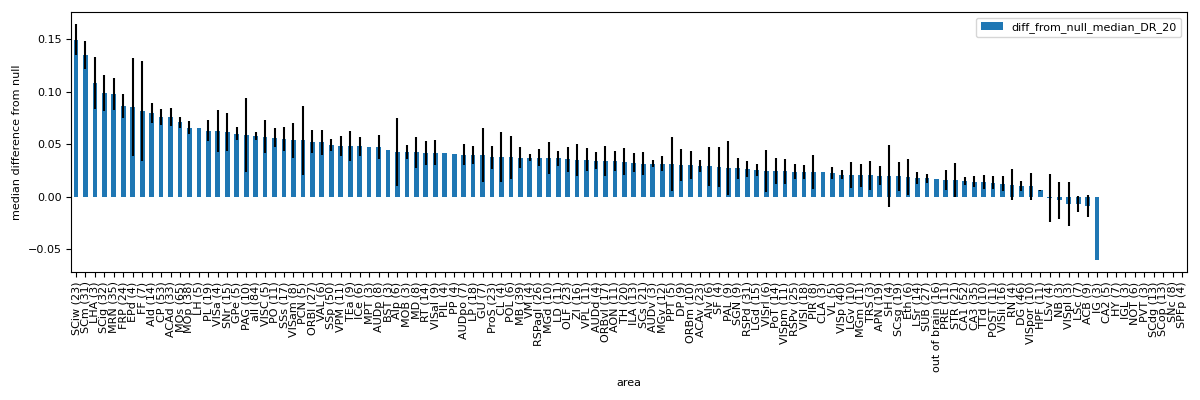

In [222]:
#barplot sorted by DR diff from median
min_n_expts=3
nu='_20'

plot_DR_diff_from_null_df=all_diff_from_null_df.query('n_expts_DR>=@min_n_expts').sort_values('diff_from_null_median_DR'+nu,ascending=False)
fig,ax=plt.subplots(1,1,figsize=(12,4))
plot_DR_diff_from_null_df.plot.bar(x='area',y=['diff_from_null_median_DR'+nu],
                                    yerr='diff_from_null_sem_DR'+nu,ax=ax)

ax.set_ylabel('median difference from null')
area_labels=[]
for i in range(plot_DR_diff_from_null_df.shape[0]):
    area_labels.append(plot_DR_diff_from_null_df['area'].iloc[i]+' ('+str(int(plot_DR_diff_from_null_df['n_expts_DR'].iloc[i]))+')')
ax.set_xticklabels(area_labels,rotation=90,ha='center')

# ax.set_ylim([0,0.2])
fig.tight_layout()



### new results

In [212]:
# new_results_path=upath.UPath("s3://aind-scratch-data/dynamic-routing/decoding/results/validate_v260_20250401_030903/")
new_results_path=upath.UPath("s3://aind-scratch-data/dynamic-routing/decoding/results/validate_v260_20250403_055132/").as_posix()

new_results_rerun_path=upath.UPath("s3://aind-scratch-data/dynamic-routing/decoding/results/validation_v260_20250401_235515/")


In [4]:
#select DR production experiments with good behavior

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-03-31\session_table_v0.260.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project').eq('DynamicRouting'),
    pl.col('is_production').eq(True),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )
# dr_session_list

In [112]:
# session_table.columns

In [ ]:
# session_table.to_pandas().query('project=="Templeton"')['subject_age_days']

In [5]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'min_n_units',
    'unit_criteria',
    # 'is_sole_recording',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [ ]:
combine_multi_probe_expr

In [214]:
new_results_df = (
    pl.scan_parquet(new_results_path+'*.parquet')
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )
    # get the means over sessions:
    .group_by('structure', 'min_n_units', 'unit_criteria')
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean(),
        pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff')
    )
    .sort(pl.col('mean_diff').mean().over('structure'), descending=True)
    .collect(streaming=True)
)

In [215]:
df_all_good_sessions = (
    pl.scan_parquet(new_results_path+'*.parquet')
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    .sort(pl.col('session_id'), descending=True)
    .collect(streaming=True)
)

In [216]:
#calculate means and sem manually for each area

df_all_good_sessions=df_all_good_sessions.to_pandas()
df_all_good_sessions

,min_n_units,electrode_group_names,structure,unit_criteria,session_id,mean_true,median_null,mean_diff
0,20,[probeF],MOp,medium,742903_2024-10-24,0.542509,0.537966,0.004543
1,20,"[probeC, probeE]",CA1,medium,742903_2024-10-24,0.538283,0.532558,0.005725
2,20,[probeE],MGm,medium,742903_2024-10-24,0.536879,0.530301,0.006578
3,20,"[probeA, probeB, probeF]",CP,medium,742903_2024-10-24,0.579463,0.546048,0.033414
4,20,[probeB],SSs,medium,742903_2024-10-24,0.580135,0.547974,0.032162
...,...,...,...,...,...,...,...,...
858,20,"[probeA, probeB, probeC]",CA1,medium,626791_2022-08-15,0.583846,0.572169,0.011678
859,20,[probeC],AUDp,medium,626791_2022-08-15,0.654702,0.593117,0.061585
860,20,[probeC],TEa,medium,626791_2022-08-15,0.519392,0.534504,-0.015112
861,20,[probeA],RSPd,medium,626791_2022-08-15,0.574162,0.583632,-0.009470


In [217]:
new_results_by_area_df={
    'structure':[],
    'mean_diff':[],
    'sem_diff':[],
    'n_sessions':[],
}

for area in df_all_good_sessions['structure'].unique():
    area_df=df_all_good_sessions.query('structure==@area')
    mean_diff=area_df['mean_diff'].mean()
    sem_diff=area_df['mean_diff'].sem()

    new_results_by_area_df['structure'].append(area)
    new_results_by_area_df['mean_diff'].append(mean_diff)
    new_results_by_area_df['sem_diff'].append(sem_diff)
    new_results_by_area_df['n_sessions'].append(area_df.shape[0])

new_results_by_area_df=pd.DataFrame(new_results_by_area_df)

In [218]:
new_results_by_area_df

,structure,mean_diff,sem_diff,n_sessions
0,MOp,0.066312,0.006642,27
1,CA1,0.022849,0.004109,37
2,MGm,0.033414,0.010764,7
3,CP,0.081701,0.007966,38
4,SSs,0.065047,0.011772,13
...,...,...,...,...
77,SF,0.032491,0.017751,3
78,PAG,0.083700,0.029608,3
79,VISam,0.041151,0.019475,6
80,VPM,0.043055,0.011620,8


<Axes: xlabel='structure'>

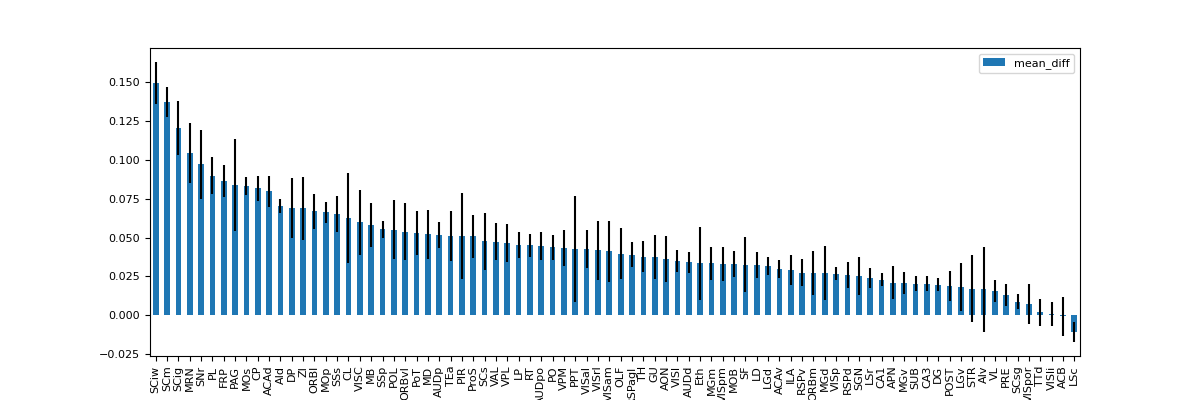

In [219]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
new_results_by_area_df.query('n_sessions>=3').sort_values(by='mean_diff',ascending=False).plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)

In [223]:
#merge new and old results
old=plot_DR_diff_from_null_df[['area','diff_from_null_median_DR_20','diff_from_null_sem_DR_20','n_expts_DR']]
# new=new_results_by_area_df.query('n_sessions>=3')
new=new_results_df.to_pandas()

merged=pd.merge(left=old,right=new,left_on='area',right_on='structure',suffixes=('_old','_new'))
merged

,area,diff_from_null_median_DR_20,diff_from_null_sem_DR_20,n_expts_DR,structure,min_n_units,unit_criteria,mean_true,median_null,mean_diff,sem_diff
0,SCiw,0.149500,0.014980,23.0,SCiw,20,medium,0.795347,0.646025,0.149321,0.022415
1,SCm,0.134627,0.013022,31.0,SCm,20,medium,0.777867,0.640732,0.137135,0.015998
2,SCig,0.098766,0.016968,32.0,SCig,20,medium,0.742530,0.622135,0.120395,0.027826
3,MRN,0.097725,0.015207,35.0,MRN,20,medium,0.738611,0.634447,0.104165,0.032518
4,FRP,0.086421,0.011245,24.0,FRP,20,medium,0.704016,0.617747,0.086269,0.016950
...,...,...,...,...,...,...,...,...,...,...,...
77,VISli,0.012357,0.007393,16.0,VISli,20,medium,0.563297,0.562522,0.000775,0.011315
78,DG,0.009944,0.004648,46.0,DG,20,medium,0.571642,0.552011,0.019632,0.006386
79,VISpor,0.009682,0.012529,10.0,VISpor,20,medium,0.570322,0.563233,0.007088,0.021542
80,LSc,-0.007360,0.007496,7.0,LSc,20,medium,0.517740,0.528454,-0.010714,0.021046


In [224]:
# .filter(
#     combine_multi_probe_expr,
#     pl.col('is_all_trials').not_(),
#     pl.col('session_id').is_in(dr_session_list),
#     pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
# )

Text(0.5, 1.0, 'compare old vs. new decoding methods')

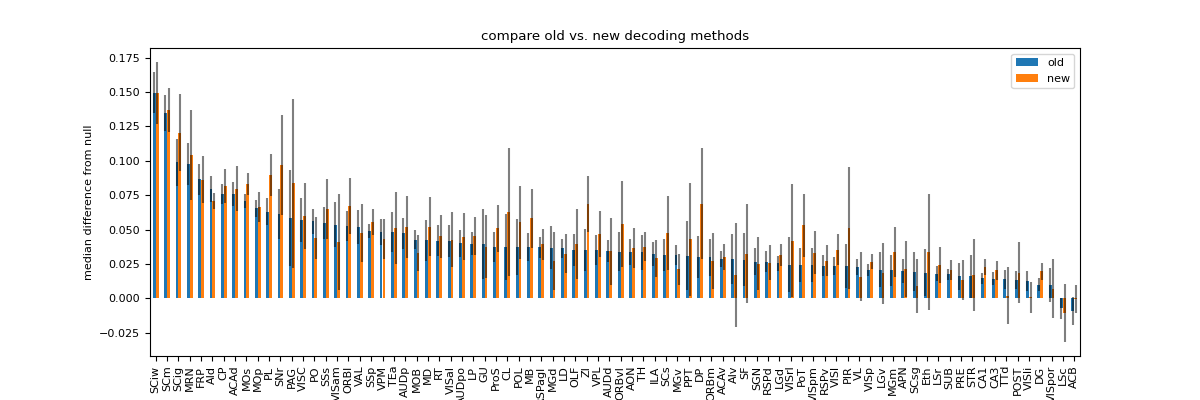

In [254]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
merged.plot.bar(x='area',y=['diff_from_null_median_DR_20','mean_diff'],ax=ax)
ax.errorbar(x=np.arange(len(merged))-0.15,y=merged['diff_from_null_median_DR_20'],yerr=merged['diff_from_null_sem_DR_20'],linestyle='None',color='k',alpha=0.5)
ax.errorbar(x=np.arange(len(merged))+0.15,y=merged['mean_diff'],yerr=merged['sem_diff'],linestyle='None',color='k',alpha=0.5)
ax.set_ylabel('median difference from null')
ax.legend(['old','new'])
ax.set_title('compare old vs. new decoding methods')

Text(0.5, 1.0, 'pearson r=0.92, p=3.468e-34')

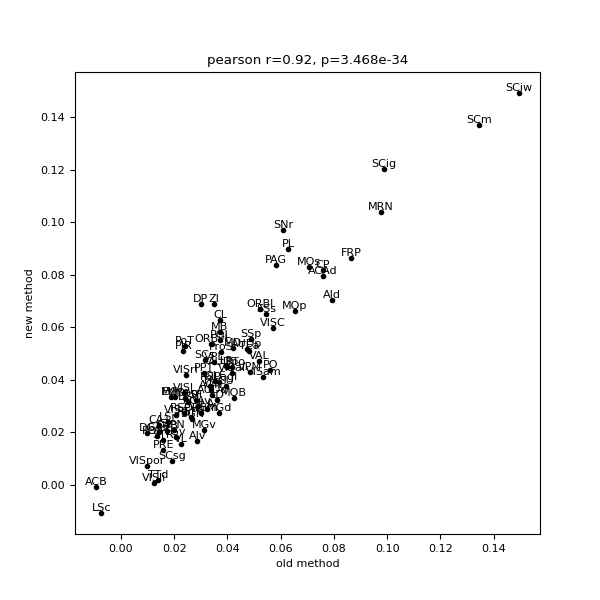

In [255]:
#get pearson correlation
r,p=stats.pearsonr(merged['diff_from_null_median_DR_20'],merged['mean_diff'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged['diff_from_null_median_DR_20'],merged['mean_diff'],marker='.',color='k')
#plot name of area above each point
for i in range(merged.shape[0]):
    ax.text(merged['diff_from_null_median_DR_20'].iloc[i],merged['mean_diff'].iloc[i],merged['area'].iloc[i],fontsize=8,ha='center',va='bottom')
ax.set_xlabel('old method')
ax.set_ylabel('new method')
ax.set_title('pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))

## session-by-session correlation

In [227]:
df_all_sessions = (
    pl.scan_parquet(new_results_path+'*.parquet')
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        # pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by('session_id', 'structure', 'electrode_group_names','min_n_units', 'unit_criteria', 'repeat_idx')
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
    )
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    .sort('session_id', descending=True)
    .collect(streaming=True)
)
# df_all_sessions_pd = df_all_sessions.to_pandas()
# df_all_sessions

In [236]:
df_all_sessions_re_run = (
    pl.scan_parquet(new_results_rerun_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        # pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    .sort(pl.col('session_id'), descending=True)
    .collect(streaming=True)
)
# df_all_sessions_re_run_pd = df_all_sessions_re_run.to_pandas()

In [238]:
#drop probe names bc they could be in a different order!

df_new_plus_rerun_results = (
    df_all_sessions.drop('unit_criteria','min_n_units',strict=False)
    .with_columns(
        pl.col('electrode_group_names').list.sort()
    )
    .join(
        df_all_sessions_re_run.drop('unit_criteria','min_n_units',strict=False)
        .with_columns(
            pl.col('electrode_group_names').list.sort()
        ),
        on=grouping_cols-{'unit_criteria','min_n_units'},
        how='inner',
        suffix='_new_re_run'
    )
)

df_new_plus_rerun_results.unique(['session_id','structure','electrode_group_names'])

electrode_group_names,structure,session_id,mean_true,median_null,mean_diff,mean_true_new_re_run,median_null_new_re_run,mean_diff_new_re_run
list[str],str,str,f64,f64,f64,f64,f64,f64
"[""probeD""]","""DG""","""703880_2024-04-18""",0.583676,0.546757,0.036919,0.588853,0.553734,0.035119
"[""probeA""]","""APN""","""733780_2024-09-06""",0.572891,0.553939,0.018952,0.565314,0.553049,0.012265
"[""probeC""]","""VISli""","""699847_2024-04-17""",0.573056,0.535831,0.037225,0.585241,0.535435,0.049806
"[""probeB""]","""RSPd""","""620263_2022-07-27""",0.579948,0.583171,-0.003223,0.567794,0.575557,-0.007763
"[""probeB"", ""probeD""]","""APN""","""726088_2024-06-20""",0.604777,0.574229,0.030548,0.597988,0.567091,0.030897
"[""probeD""]","""CP""","""686176_2023-12-05""",0.713382,0.614643,0.098739,0.710856,0.615747,0.095109
"[""probeB""]","""VISpm""","""670181_2023-07-18""",0.55739,0.565299,-0.007909,0.562899,0.56903,-0.006131
"[""probeC""]","""RN""","""690706_2023-11-29""",0.650901,0.579832,0.071069,0.640342,0.580925,0.059417
"[""probeD"", ""probeE"", ""probeF""]","""ACAd""","""674562_2023-10-05""",0.697174,0.63153,0.065644,0.681089,0.615482,0.065607


In [229]:
all_decoder_results['mean_diff']=all_decoder_results['true_accuracy_20']-all_decoder_results['null_accuracy_median_20']
old_decoder_results=all_decoder_results.query('(probe=="all" or probe.isna()) and n_units>=20')[['area','session_id','project','mean_diff','true_accuracy_20','null_accuracy_median_20','n_units']].reset_index()
old_decoder_results

,index,area,session_id,project,mean_diff,true_accuracy_20,null_accuracy_median_20,n_units
0,0,DG,620263_2022-07-26,TempletonPilotSession,0.001713,0.540771,0.539057,83
1,2,VISp,620263_2022-07-26,TempletonPilotSession,-0.004562,0.511391,0.515953,116
2,4,TEa,620263_2022-07-26,TempletonPilotSession,-0.011509,0.540262,0.551771,69
3,5,VISli,620263_2022-07-26,TempletonPilotSession,0.000279,0.519274,0.518995,105
4,6,VISl,620263_2022-07-26,TempletonPilotSession,0.011907,0.540007,0.528100,23
...,...,...,...,...,...,...,...,...
2048,3815,MOp,742903_2024-10-24,DynamicRouting,0.010889,0.543711,0.532822,142
2049,3816,all,742903_2024-10-24,DynamicRouting,0.015817,0.554715,0.538898,1365
2050,3817,CA1,742903_2024-10-24,DynamicRouting,0.013949,0.541347,0.527398,48
2051,3818,CP,742903_2024-10-24,DynamicRouting,0.043241,0.575184,0.531942,321


In [ ]:
#get unique session_id - structure combinations in new results
new_results_unique_session_structures=pl.scan_parquet(new_results_path+'*.parquet').select('session_id','structure').unique().collect()

In [ ]:
#compare unique session structures in old and new results
old_results_unique_session_structures=old_decoder_results[['session_id','area']].drop_duplicates().rename(columns={"area": "structure"})

new_results_unique_session_structures_pd=new_results_unique_session_structures.to_pandas()

In [ ]:
all_combos_merge=pd.merge(
    left=old_results_unique_session_structures,
    right=new_results_unique_session_structures_pd,
    on=['session_id','structure'],
    how='outer',
    indicator=True
)
all_combos_merge

,session_id,structure,_merge
0,620263_2022-07-26,ACAd,both
1,620263_2022-07-26,ACAv,both
2,620263_2022-07-26,CA1,both
3,620263_2022-07-26,DG,both
4,620263_2022-07-26,LSr,both
...,...,...,...
2068,742903_2024-10-24,PoT,both
2069,742903_2024-10-24,SSp,both
2070,742903_2024-10-24,SSs,both
2071,742903_2024-10-24,VISal,both


In [ ]:
all_combos_merge.query('_merge=="left_only"')

,session_id,structure,_merge
10,620263_2022-07-26,all,left_only
22,620263_2022-07-27,all,left_only
32,620264_2022-08-02,all,left_only
48,626791_2022-08-15,all,left_only
55,626791_2022-08-16,all,left_only
...,...,...,...
2021,741148_2024-10-18,all,left_only
2031,742903_2024-10-21,all,left_only
2047,742903_2024-10-22,all,left_only
2059,742903_2024-10-23,all,left_only


Text(0, 0.5, 'number of unique areas')

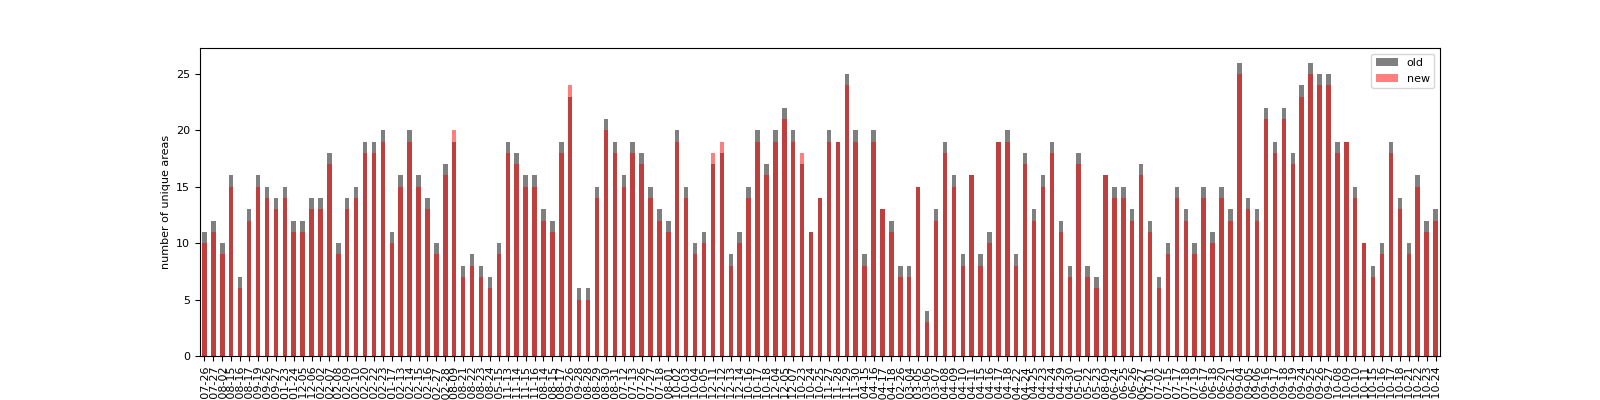

In [256]:
#count unique areas in each session
fig,ax=plt.subplots(1,1,figsize=(16,4))
old_results_unique_session_structures.groupby('session_id').count().plot.bar(ax=ax,y='structure',color='k',label='old',alpha=0.5)
new_results_unique_session_structures_pd.groupby('session_id').count().plot.bar(ax=ax,y='structure',color='r',label='new',alpha=0.5)

ax.set_ylabel('number of unique areas')

In [240]:
#merge old and new results on area and session_id + merge re-run results

old_decoder_results['session_id']=old_decoder_results['session_id'].astype(str)
# merged_all_sessions=pd.merge(left=df_all_sessions,
#                              right=df_all_sessions_re_run[['session_id','structure','mean_diff']],
#                              on=['session_id','structure'],suffixes=('_new','_new_rerun'))
# merged_all_sessions=pd.merge(left=merged_all_sessions,right=old_decoder_results,left_on=['structure','session_id'],right_on=['area','session_id'],suffixes=('_new','_old'))

# merged_all_sessions=pd.merge(left=df_all_sessions.to_pandas(),right=old_decoder_results,
#                              left_on=['structure','session_id'],right_on=['area','session_id'],suffixes=('_new','_old'))
# merged_all_sessions=pd.merge(left=merged_all_sessions,right=df_all_sessions_re_run[['structure','session_id','mean_diff_new_re_run']],left_on=['structure','session_id'],right_on=['structure','session_id'],suffixes=('_new','_new_rerun'))

merged_all_sessions=pd.merge(left=df_new_plus_rerun_results.to_pandas(),right=old_decoder_results,
                             left_on=['structure','session_id'],right_on=['area','session_id'],
                             suffixes=('_new','_old'))

merged_all_sessions

,electrode_group_names,structure,session_id,mean_true,median_null,mean_diff_new,mean_true_new_re_run,median_null_new_re_run,mean_diff_new_re_run,index,area,project,mean_diff_old,true_accuracy_20,null_accuracy_median_20,n_units
0,[probeE],LGd,742903_2024-10-24,0.532699,0.524717,0.007982,0.536319,0.526907,0.009412,3810,LGd,DynamicRouting,0.021440,0.546533,0.525093,68
1,[probeC],VISal,742903_2024-10-24,0.515271,0.512691,0.002580,0.520832,0.509604,0.011228,3805,VISal,DynamicRouting,0.016436,0.528230,0.511794,40
2,[probeB],SSs,742903_2024-10-24,0.580135,0.547974,0.032162,0.582966,0.554952,0.028014,3799,SSs,DynamicRouting,0.022132,0.571962,0.549829,116
3,[probeC],AUDpo,742903_2024-10-24,0.558521,0.548335,0.010186,0.556255,0.547889,0.008366,3804,AUDpo,DynamicRouting,0.010525,0.564362,0.553836,80
4,[probeE],PoT,742903_2024-10-24,0.519077,0.516174,0.002903,0.523958,0.518903,0.005055,3806,PoT,DynamicRouting,0.000082,0.522495,0.522413,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,"[probeB, probeC]",CA1,620263_2022-07-26,0.556998,0.560838,-0.003839,0.579648,0.570839,0.008810,13,CA1,TempletonPilotSession,0.006585,0.570842,0.564257,213
1743,[probeF],MOs,620263_2022-07-26,0.572197,0.574592,-0.002396,0.563913,0.572667,-0.008754,11,MOs,TempletonPilotSession,0.001473,0.570179,0.568706,64
1744,[probeC],VISl,620263_2022-07-26,0.540526,0.531798,0.008728,0.536752,0.531200,0.005552,6,VISl,TempletonPilotSession,0.011907,0.540007,0.528100,23
1745,[probeC],VISli,620263_2022-07-26,0.538486,0.520807,0.017679,0.534790,0.522905,0.011885,5,VISli,TempletonPilotSession,0.000279,0.519274,0.518995,105


### compare old vs. new

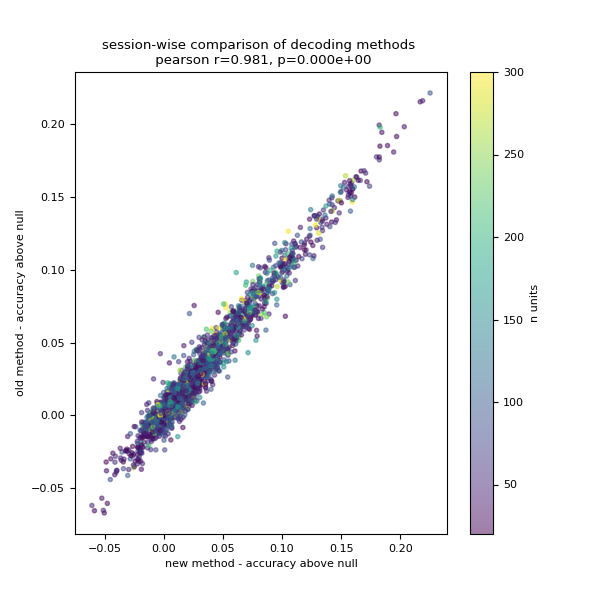

In [257]:
r,p=stats.pearsonr(merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
# ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_old'],marker='.',color='k')
points=ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_old'],marker='.',
                  c=merged_all_sessions['n_units'],alpha=0.5,cmap='viridis',vmin=20,vmax=300)
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('old method - accuracy above null')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))
fig.colorbar(label='n units',mappable=points,)


Text(0.5, 1.0, 'n_units <= 30 \n pearson r=0.987, p=9.043e-194')

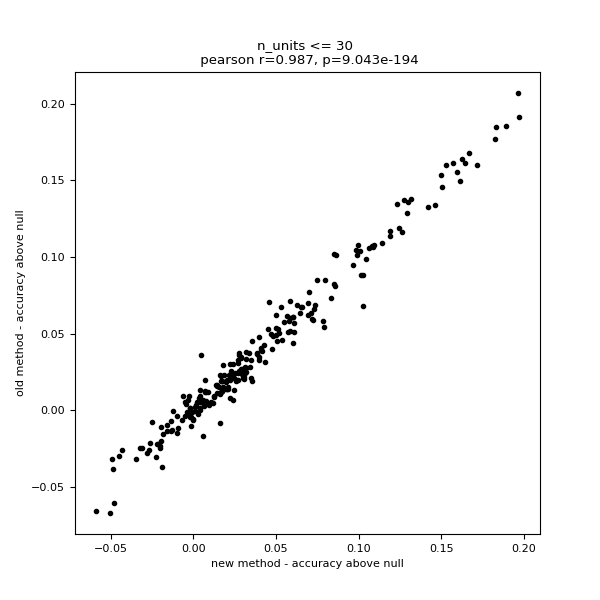

In [258]:
max_n_units=30
filter_n_units=merged_all_sessions.query('n_units<=@max_n_units')

r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(filter_n_units['mean_diff_new'],filter_n_units['mean_diff_old'],marker='.',color='k')
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('old method - accuracy above null')
ax.set_title('n_units <= '+str(max_n_units)+' \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


In [244]:
n_units_range=np.arange(20,350,20)

n_units_r_list=[]
n_units_p_list=[]

for n_units in n_units_range:
    min_n_units=n_units-10
    max_n_units=n_units+10
    filter_n_units=merged_all_sessions.query('n_units>@min_n_units and n_units<=@max_n_units')
    if len(filter_n_units)<2:
        n_units_r_list.append(np.nan)
        n_units_p_list.append(np.nan)
        continue
    r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])
    n_units_r_list.append(r)
    n_units_p_list.append(p)

Text(0, 0.5, 'pearson r')

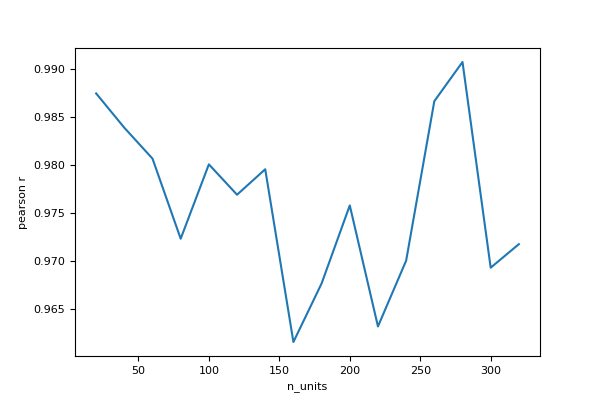

In [245]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(n_units_range,n_units_r_list)
ax.set_xlabel('n_units')
ax.set_ylabel('pearson r')

# n_units_r_list

In [246]:
# filter_n_units

Text(0.5, 1.0, 'session-wise comparison of decoding methods \n pearson r=0.991, p=0.000e+00')

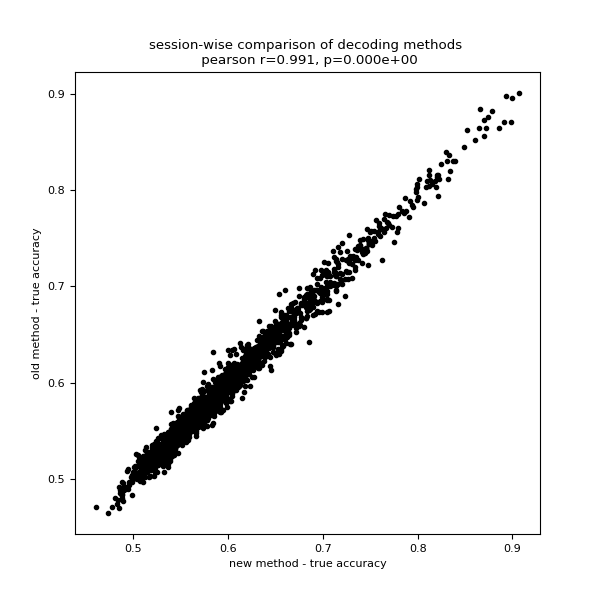

In [247]:
r,p=stats.pearsonr(merged_all_sessions.query('~mean_true.isna() and ~true_accuracy_20.isna()')['mean_true'],
                   merged_all_sessions.query('~mean_true.isna() and ~true_accuracy_20.isna()')['true_accuracy_20'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged_all_sessions['mean_true'],merged_all_sessions['true_accuracy_20'],marker='.',color='k')
ax.set_xlabel('new method - true accuracy')
ax.set_ylabel('old method - true accuracy')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


Text(0.5, 1.0, 'session-wise comparison of decoding methods \n pearson r=0.987, p=0.000e+00')

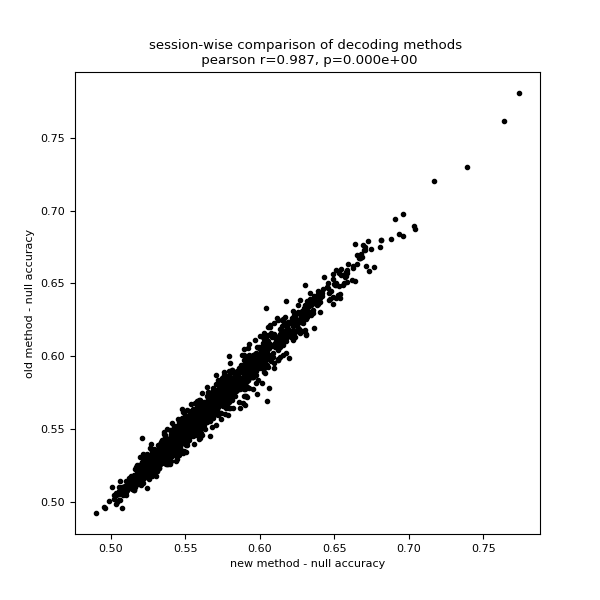

In [248]:
r,p=stats.pearsonr(merged_all_sessions.query('~median_null.isna() and ~null_accuracy_median_20.isna()')['median_null'],
                   merged_all_sessions.query('~median_null.isna() and ~null_accuracy_median_20.isna()')['null_accuracy_median_20'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged_all_sessions['median_null'],merged_all_sessions['null_accuracy_median_20'],marker='.',color='k')
ax.set_xlabel('new method - null accuracy')
ax.set_ylabel('old method - null accuracy')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


### compare new vs. new re-run

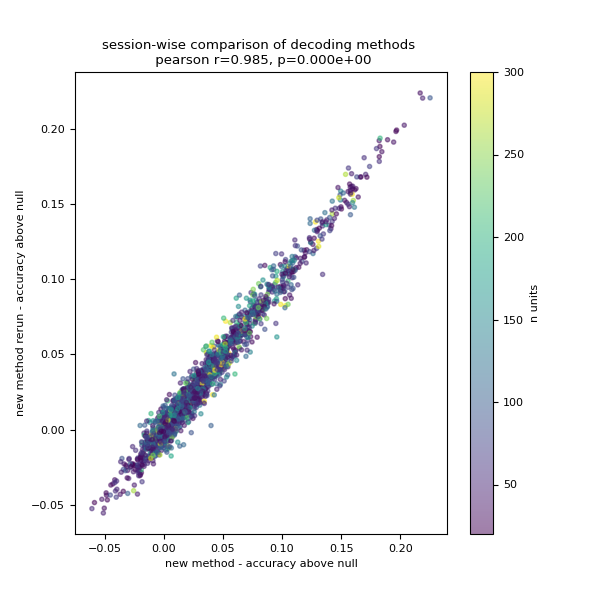

In [249]:
r,p=stats.pearsonr(merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_new_re_run.isna()')['mean_diff_new'],
                   merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_new_re_run.isna()')['mean_diff_new_re_run'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
# ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_old'],marker='.',color='k')
points=ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_new_re_run'],marker='.',
                  c=merged_all_sessions['n_units'],alpha=0.5,cmap='viridis',vmin=20,vmax=300)
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('new method rerun - accuracy above null')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))
fig.colorbar(label='n units',mappable=points,)


Text(0.5, 1.0, 'n_units <= 30 \n pearson r=0.994, p=1.375e-230')

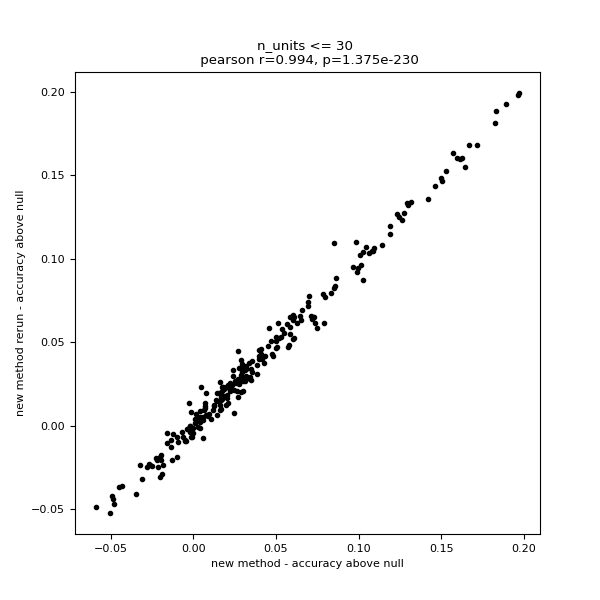

In [250]:
max_n_units=30
filter_n_units=merged_all_sessions.query('n_units<=@max_n_units')

r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_new_re_run.isna()')['mean_diff_new'],
                   filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_new_re_run.isna()')['mean_diff_new_re_run'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(filter_n_units['mean_diff_new'],filter_n_units['mean_diff_new_re_run'],marker='.',color='k')
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('new method rerun - accuracy above null')
ax.set_title('n_units <= '+str(max_n_units)+' \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


## trialwise correlation

correlations should be high between areas in the same session, even across different decoder runs

In [147]:
old_trialwise_results_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\logreg_many_n_units_medium_criteria_2025-01-08\decoder_confidence_all_trials_20_units.pkl"

In [148]:
old_trialwise_results=pd.read_pickle(old_trialwise_results_path)
# old_trialwise_results

In [149]:
old_trialwise_results=old_trialwise_results.query('probe=="all" or probe==""')

In [ ]:
# temp_path="s3://aind-scratch-data/dynamic-routing/decoding/results/validate_v260_20250403_203859"

In [134]:
df_predict_proba_sessions = (
    pl.scan_parquet(new_results_path+'*.parquet')
    # pl.scan_parquet(temp_path+'/*.parquet')
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
        
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        # pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    ).drop('unit_ids') 
    .sort('session_id', descending=True)
    .collect(streaming=True)
)


In [260]:
# pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.260/consolidated/units.parquet').select('session_id').collect()
# df_predict_proba_sessions['session_id'].unique()

In [135]:
predict_proba_with_repeats = (
    df_predict_proba_sessions
    .lazy()
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.260/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'min_n_units', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.260/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_context', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'repeat_idx')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_context', 'stim_name', 'is_response'),
    )
    .sort('session_id', 'structure', 'repeat_idx')
    .collect()
)

In [350]:
# df_predict_proba_sessions.filter(
#     pl.col('session_id').eq('742903_2024-10-24'),
#     pl.col('structure').eq('MOp')
# )
predict_proba_with_repeats

session_id,structure,repeat_idx,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_context,stim_name,is_response
str,str,i8,f64,u32,list[f64],list[i64],list[bool],list[str],list[bool]
"""620263_2022-07-26""","""ACAd""",0,0.590661,111,"[0.452873, 0.330548, … 0.349631]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",1,0.584595,111,"[0.243628, 0.262098, … 0.353286]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",2,0.64454,111,"[0.251289, 0.264339, … 0.549621]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",3,0.558734,111,"[0.267601, 0.317823, … 0.346854]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",4,0.634961,111,"[0.240721, 0.454918, … 0.745772]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",5,0.666783,111,"[0.351549, 0.349158, … 0.332255]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",6,0.62977,111,"[0.426693, 0.393125, … 0.601474]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",7,0.606932,111,"[0.16278, 0.132901, … 0.344539]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAd""",8,0.678641,111,"[0.361643, 0.486885, … 0.645288]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"


In [63]:
predict_proba_with_repeats.filter(
    pl.col('total_n_units').eq(21),
).unique(['session_id','structure'])

session_id,structure,repeat_idx,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_context,stim_name,is_response
str,str,i8,f64,u32,list[f64],list[i64],list[bool],list[str],list[bool]
"""737403_2024-09-25""","""SNr""",0,0.651313,22,"[0.067041, 0.170059, … 0.839762]","[0, 1, … 546]","[false, false, … true]","[""sound1"", ""sound1"", … ""vis2""]","[true, true, … false]"
"""714748_2024-06-24""","""FRP""",0,0.800216,22,"[0.227024, 0.85297, … 0.66876]","[0, 1, … 549]","[true, true, … false]","[""vis1"", ""vis1"", … ""vis1""]","[false, true, … true]"
"""703882_2024-04-24""","""VISp""",0,0.611248,22,"[0.665836, 0.706948, … 0.664619]","[0, 1, … 524]","[true, true, … false]","[""vis1"", ""vis1"", … ""sound1""]","[true, true, … true]"


In [137]:
# pl.Config.set_tbl_rows(50)
# predict_proba_with_repeats.unique(['session_id','structure'])

In [73]:
# !pip install altair

In [ ]:
### fancy polars plotting
# import altair as alt
# alt.data_transformers.disable_max_rows()
# (
#     predict_proba_with_repeats.filter(
#         pl.col('session_id').eq('714748_2024-06-24'),
#         pl.col('structure').eq('FRP')
#     )
#     .explode('predict_proba', 'trial_index')
#     .plot.line(
#         x='trial_index',
#         y='predict_proba',
#         color='repeat_idx:N',
#     )
# )

In [123]:
area

array(['CA1', 'OLF', 'MOs', 'ORBm', 'DG', 'CP', 'LSr', 'VISal', 'ORBvl',
       'SSs', 'FRP', 'PL', 'GU', 'LGv', 'SSp', 'ACAd', 'AIp', 'ACAv',
       'out of brain', 'ORBl', 'TTd', 'CA3', 'ILA'], dtype='<U12')

In [139]:
total_n_units=[]
repeat_std=[]
area=[]

for sel_area in predict_proba_with_repeats['structure'].unique().to_list():
    all_repeats=np.vstack(predict_proba_with_repeats.filter(pl.col('structure').eq(sel_area))['predict_proba'].to_numpy())
    total_n_units.append(predict_proba_with_repeats.filter(pl.col('structure').eq(sel_area))['total_n_units'][0])
    repeat_std.append(np.mean(np.std(all_repeats,axis=0)))
    area.append(sel_area)

total_n_units=np.array(total_n_units)
repeat_std=np.array(repeat_std)
area=np.array(area)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 479 and the array at index 25 has size 678

In [132]:
total_n_units[np.where(area==sel_area)[0][0]]
total_n_units

array([   8, 1116,   36,   17,   76,  433,  157,  169,   28,  134,  103,
         19,   86,   48,  279,  265,   98,   54,  132,   51,  857,  240,
         40])

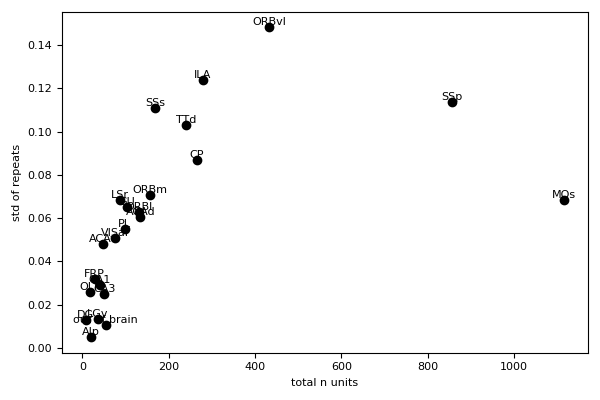

In [133]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(total_n_units,repeat_std,'ko')
for sel_area in area:
    ax.text(total_n_units[np.where(area==sel_area)[0][0]],repeat_std[np.where(area==sel_area)[0][0]],sel_area,fontsize=8,ha='center',va='bottom')
ax.set_ylabel('std of repeats')
ax.set_xlabel('total n units')
fig.tight_layout()

In [125]:
# total_n_units[area==sel_area]
np.where(area==sel_area)[0][0]

22

(0.0, 0.5)

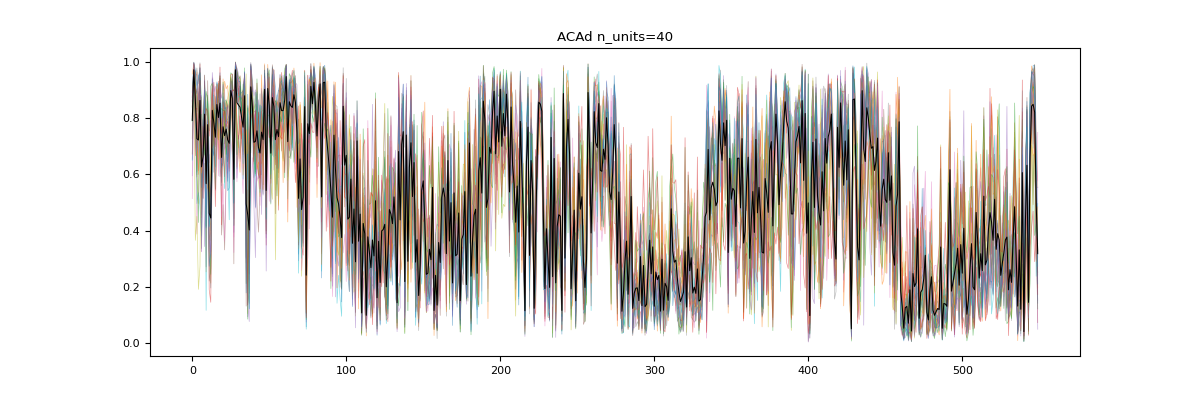

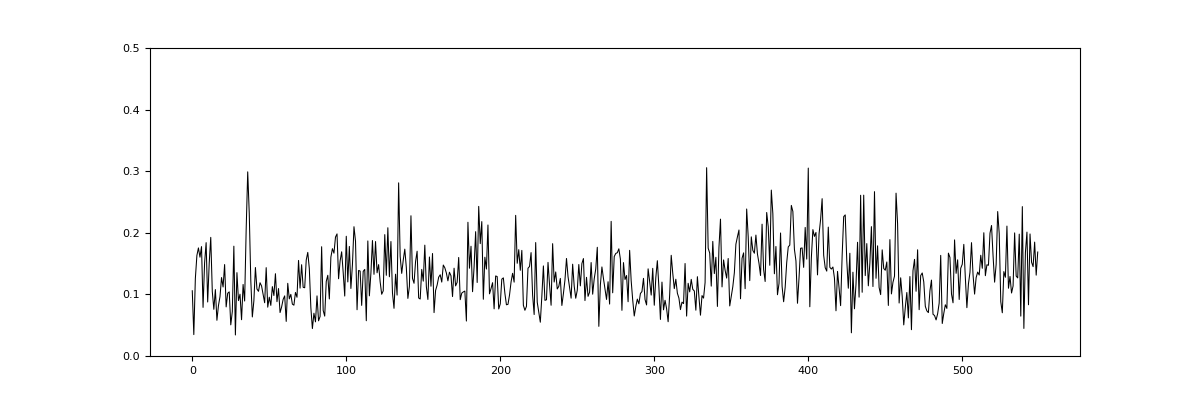

In [145]:
sel_area='ACAd'

plot_data=np.vstack(predict_proba_with_repeats.filter(
    pl.col('session_id').eq('714748_2024-06-24'),
    pl.col('structure').eq(sel_area)
)['predict_proba'].to_numpy())

total_n_units=predict_proba_with_repeats.filter(
    pl.col('session_id').eq('714748_2024-06-24'),
    pl.col('structure').eq(sel_area)
)['total_n_units']

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(plot_data.T,linewidth=0.5,alpha=0.5)
ax.plot(np.mean(plot_data,axis=0),color='k',linewidth=0.75)
ax.set_title(sel_area+' n_units='+str(total_n_units[0]))

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(np.std(plot_data,axis=0),color='k',linewidth=0.75)
ax.set_ylim([0,0.5])

In [113]:
# total_n_units

In [150]:
old_trialwise_results.columns

Index(['session', 'area', 'project', 'probe', 'cross_modal_dprime',
       'n_good_blocks', 'trial_index', 'confidence', 'predict_proba',
       'ccf_ap_mean', 'ccf_dv_mean', 'ccf_ml_mean', 'n_units'],
      dtype='object')

Text(0.5, 1.0, 'FRP 714748_2024-06-24 \n pearson r=0.998, p=0.000e+00')

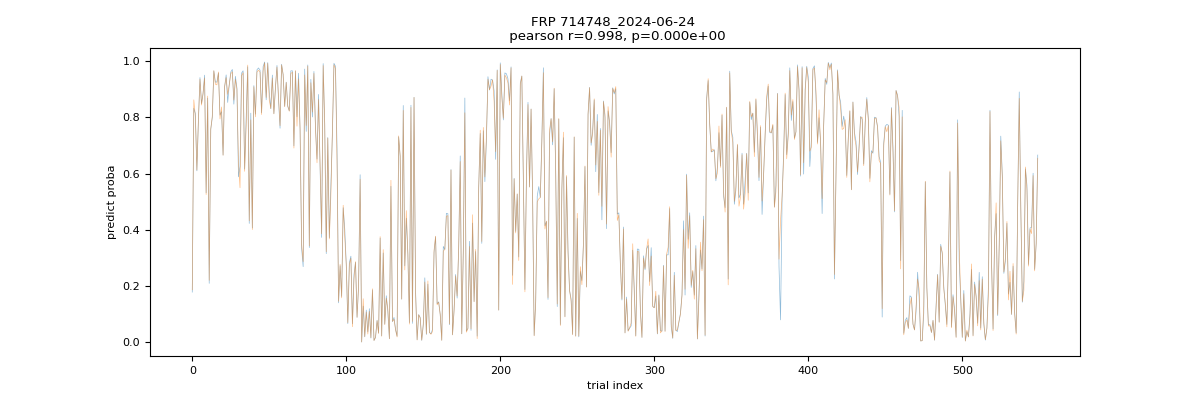

In [263]:
#compare old and new trialwise results

sel_session_id='714748_2024-06-24'
sel_area='FRP'

old_session_area_results=old_trialwise_results.query('session==@sel_session_id and area==@sel_area')['predict_proba'].values[0]

new_session_area_results=np.mean(np.vstack(predict_proba_with_repeats.filter(
    pl.col('session_id').eq(sel_session_id),
    pl.col('structure').eq(sel_area)
)['predict_proba']),axis=0)

r,p=stats.pearsonr(old_session_area_results,new_session_area_results)

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(old_session_area_results,linewidth=0.5,alpha=0.5)
ax.plot(new_session_area_results,linewidth=0.5,alpha=0.5)
ax.set_ylabel('predict proba')
ax.set_xlabel('trial index')
ax.set_title(sel_area+' '+sel_session_id+' \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))

In [264]:
unique_combos=old_trialwise_results[['session','area']].reset_index().drop_duplicates()

old_new_correlation={
    'session':[],
    'area':[],
    'r':[],
    'p':[],
    'r_rand':[],
    'p_rand':[],
}

for uc,combo in unique_combos.iterrows():
    sel_session_id=combo['session']
    sel_area=combo['area']

    old_result=old_trialwise_results.query('session==@sel_session_id and area==@sel_area')['predict_proba'].values[0]

    #old result random diff area
    n_other_areas=len(old_trialwise_results.query('session==@sel_session_id and area!=@sel_area')['area'].unique())
    random_area_idx=np.random.randint(0,n_other_areas)
    old_result_diff_area=old_trialwise_results.query('session==@sel_session_id and area!=@sel_area')['predict_proba'].values[random_area_idx]

    new_temp=predict_proba_with_repeats.filter(
        pl.col('session_id').eq(sel_session_id),
        pl.col('structure').eq(sel_area)
    )['predict_proba']

    if len(new_temp)==0:
        continue

    new_result=np.mean(np.vstack(new_temp),axis=0)

    if len(old_result)!=len(new_result):
        print('WARNING, old and new results not same length '+sel_session_id+' '+sel_area)
        continue

    r,p=stats.pearsonr(old_result,new_result)

    r_rand,p_rand=stats.pearsonr(old_result_diff_area,new_result)

    old_new_correlation['session'].append(sel_session_id)
    old_new_correlation['area'].append(sel_area)
    old_new_correlation['r'].append(r)
    old_new_correlation['p'].append(p)

    old_new_correlation['r_rand'].append(r_rand)
    old_new_correlation['p_rand'].append(p_rand)

old_new_correlation_df=pd.DataFrame(old_new_correlation)
# 

WARNING, old and new results not same length 644866_2023-02-07 ORBl
WARNING, old and new results not same length 644866_2023-02-07 PoT
WARNING, old and new results not same length 644866_2023-02-07 Eth
WARNING, old and new results not same length 644866_2023-02-07 POL
WARNING, old and new results not same length 644866_2023-02-07 RSPd
WARNING, old and new results not same length 644866_2023-02-07 MGv
WARNING, old and new results not same length 644866_2023-02-07 MGd
WARNING, old and new results not same length 644866_2023-02-07 VISp
WARNING, old and new results not same length 644866_2023-02-07 CA1
WARNING, old and new results not same length 644866_2023-02-07 TEa
WARNING, old and new results not same length 644866_2023-02-07 RT
WARNING, old and new results not same length 644866_2023-02-07 SSp
WARNING, old and new results not same length 644866_2023-02-07 DG
WARNING, old and new results not same length 644866_2023-02-07 LP
WARNING, old and new results not same length 644866_2023-02-07

In [266]:
old_new_correlation_df

,session,area,r,p,r_rand,p_rand
0,620263_2022-07-26,DG,-0.911352,7.258537e-261,-0.380690,1.234793e-24
1,620263_2022-07-26,VISp,-0.923818,5.262260e-282,-0.327359,2.831804e-18
2,620263_2022-07-26,TEa,0.929178,3.118431e-292,0.368948,3.955220e-23
3,620263_2022-07-26,VISli,0.904928,3.688731e-251,0.474552,4.296669e-39
4,620263_2022-07-26,VISl,0.990810,0.000000e+00,0.276252,2.970920e-13
...,...,...,...,...,...,...
1843,742903_2024-10-24,CA3,0.996305,0.000000e+00,0.368392,1.414528e-18
1844,742903_2024-10-24,MOp,0.931988,3.588865e-236,0.611082,7.058974e-56
1845,742903_2024-10-24,CA1,0.981366,0.000000e+00,0.640376,7.530940e-63
1846,742903_2024-10-24,CP,0.932987,8.109380e-238,0.450002,6.195899e-28


In [290]:
# np.sum(np.histogram(np.abs(old_new_correlation_df['r_rand']))[0])

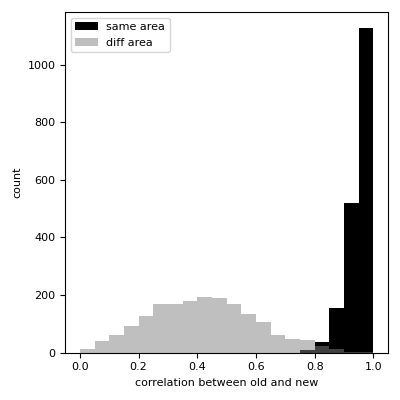

In [291]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
x0=ax.hist(np.abs(old_new_correlation_df['r']),bins=np.arange(0,1.01,0.05),color='k',label='same area')
x1=ax.hist(np.abs(old_new_correlation_df['r_rand']),bins=np.arange(0,1.01,0.05),color='grey',alpha=0.5,label='diff area')
ax.legend()
ax.set_ylabel('count')
ax.set_xlabel('correlation between old and new')
fig.tight_layout()

In [293]:
np.sum(x0[0])
np.sum(x1[0])

1848.0

In [186]:
# old_result

In [294]:
old_new_correlation_df.query('r<0')['session'].unique()

array(['620263_2022-07-26', '620263_2022-07-27', '620264_2022-08-02',
       '628801_2022-09-19', '636397_2022-09-26', '636397_2022-09-27',
       '644547_2022-12-05', '644547_2022-12-06', '646318_2023-01-17',
       '649944_2023-02-27', '649944_2023-02-28', '662983_2023-05-15',
       '668759_2023-07-12', '668759_2023-07-13', '670180_2023-07-26',
       '670180_2023-07-27', '670181_2023-07-18', '670248_2023-08-01'],
      dtype=object)

In [300]:
session_table.to_pandas().query('session_id=="737403_2024-09-27"')['cross_modal_dprime_vis_blocks']

157    -2.8138591668704;-1.339871714887251;-1.7329291...
Name: cross_modal_dprime_vis_blocks, dtype: object

In [301]:
session_table.to_pandas().query('session_id=="737403_2024-09-27"')['is_good_behavior']

157    False
Name: is_good_behavior, dtype: bool

In [306]:
# session_table.to_pandas().query('project=="DynamicRouting" and is_production')
session_table_new_path=r"D:\session_table_v0.265.csv"
session_table_new=pl.read_csv(session_table_new_path)

In [333]:
session_table_new.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
)
# session_table_new['issues']

session_id,is_production,project,date,time,subject_id,subject_age_days,subject_sex,subject_genotype,implant,rig,experimenters,notes,issues,allen_path,cloud_path,task_version,ephys_day,behavior_day,epochs,is_ephys,is_deep_insertions,is_sync,is_video,is_templeton,is_annotated,is_hab,is_task,is_invalid_times,is_naive,is_context_naive,is_late_autorewards,is_spontaneous,is_spontaneous_rewards,is_rf_mapping,is_optotagging,is_optotagging_control,is_opto_perturbation,is_injection_perturbation,is_opto_control,is_injection_control,probe_letters_available,probe_letters_to_skip,probe_letters_annotated,deep_probe_letters_to_skip,areas_perturbed,areas_recorded,task_duration,mean_intra_modal_dprime_vis,mean_intra_modal_dprime_aud,n_passing_blocks,cross_modal_dprime_vis_blocks,cross_modal_dprime_aud_blocks,n_hits,n_contingent_rewards,n_responses,n_trials,is_first_block_aud,is_first_block_vis,is_engaged,is_good_behavior,is_bad_behavior,is_stage_5_passed
str,bool,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,f64,f64,f64,i64,str,str,str,str,str,str,bool,bool,bool,bool,bool,bool
"""626791_2022-08-15""",true,"""DynamicRouting""","""2022-08-15""","""11:22:17""",626791,146,"""M""","""wt/wt""","""Templeton""","""NP3""","""Jackie Kuyat""",null,"""""","""//allen/programs/mindscope/wor…","""s3://aind-ephys-data/ecephys_6…","""stage 5 ori tone""",1,41,"""DynamicRouting1;RFMapping""",true,false,true,true,false,true,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,"""ABCF""","""DE""","""ABCF""","""""",null,"""AUDp;AUDpo;CA1;CA3;CP;DG;IGL;I…",3597.08371,1.883526,1.594131,5,"""2.9743649003466195;1.373955456…","""1.9912253204260852;0.0;2.11251…","""19.0;15.0;16.0;15.0;18.0;17.0""","""19.0;15.0;16.0;15.0;18.0;17.0""","""34.0;35.0;43.0;51.0;39.0;37.0""","""87.0;72.0;86.0;72.0;87.0;75.0""",false,true,true,true,false,false
"""626791_2022-08-16""",true,"""DynamicRouting""","""2022-08-16""","""12:42:51""",626791,147,"""M""","""wt/wt""","""Templeton""","""NP3""","""Jackie Kuyat""",null,"""""","""//allen/programs/mindscope/wor…","""s3://aind-ephys-data/ecephys_6…","""stage 5 tone ori""",2,42,"""DynamicRouting1;RFMapping""",true,false,true,true,false,true,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,"""ABC""","""DE""","""ABC""","""""",null,"""ACAd;ACAv;AD;CA1;CA3;DG;ICe;MB…",3619.38843,1.807613,1.522397,4,"""2.41743716418378;0.94708425895…","""1.2400160748594753;0.196327841…","""18.0;19.0;12.0;18.0;15.0;16.0""","""18.0;19.0;12.0;18.0;15.0;16.0""","""46.0;41.0;31.0;51.0;37.0;36.0""","""83.0;87.0;88.0;84.0;70.0;88.0""",true,false,true,false,true,false
"""626791_2022-08-17""",true,"""DynamicRouting""","""2022-08-17""","""13:24:54""",626791,148,"""M""","""wt/wt""","""Templeton""","""NP3""","""Jackie Kuyat""",null,"""""","""//allen/programs/mindscope/wor…","""s3://aind-ephys-data/ecephys_6…","""stage 5 ori tone""",3,43,"""DynamicRouting1;RFMapping""",true,false,true,true,false,true,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,"""ABCF""","""DE""","""ABCF""","""""",null,"""AUDpo;CA1;CP;DG;LP;MOp;MOs;PoT…",3607.81026,2.539225,3.0431,3,"""1.6557153637903215;0.321287007…","""1.8157186865251573;0.853076570…","""19.0;17.0;18.0;17.0;16.0;17.0""","""19.0;17.0;18.0;17.0;16.0;17.0""","""37.0;34.0;42.0;41.0;41.0;36.0""","""90.0;86.0;85.0;85.0;85.0;81.0""",false,true,true,false,true,false
"""636766_2023-01-23""",true,"""DynamicRouting""","""2023-01-23""","""11:50:21""",636766,232,"""F""","""VGAT-ChR2-YFP/wt""","""2002""","""NP3""","""Jackie Kuyat""",null,"""""","""//allen/programs/mindscope/wor…","""s3://aind-ephys-data/ecephys_6…","""opto 3 ori tone""",1,105,"""RFMapping;DynamicRouting1""",true,false,true,true,false,true,false,true,false,false,false,false,false,false,true,false,false,true,false,false,false,"""

In [342]:
dr_session_table=session_table_new.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
)

In [343]:
good_block_dprime_thresh=1.0
min_good_blocks_each_modality=2
min_good_blocks_total=4

#try to use polars to compute different session behavior criteria, find how many session pass each one
dr_session_table.filter(
    pl.col('cross_modal_dprime_vis_blocks').ge(good_block_dprime_thresh).sum().ge(min_good_blocks_each_modality) &
    pl.col('cross_modal_dprime_aud_blocks').ge(good_block_dprime_thresh).sum().ge(min_good_blocks_each_modality)
)

    # session_id=session_row['session_id']
    # n_overall_good_blocks=np.sum([session_row['cross_modal_dprime_vis_blocks']>dprime_thresh,
    #                               session_row['cross_modal_dprime_aud_blocks']>dprime_thresh])
    # print(session_id,n_overall_good_blocks)
    # break

ComputeError: cannot compare string with numeric type (f64)

In [349]:
# dr_session_table['cross_modal_dprime_vis_blocks']

In [339]:
# session_row['cross_modal_dprime_vis_blocks']

'2.9743649003466195;1.373955456306982;1.7747955261736947'